<a href="https://colab.research.google.com/github/Thanos002/IL_Measurement/blob/main/IL_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import json
import pandas as pd
import aiohttp
import asyncio
import json
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import time
from datetime import datetime

In [ ]:
class Token:
  def __init__(self, name, id, type, decimals):
    self.name = name
    self.id = id
    self.type = type
    self.decimals = decimals

class Pool:
  def __init__(self, id, fee, token0, token1):
    self.id = id
    self.group = token0.type + "/" + token1.type
    self.name = token0.name + "_" + token1.name + "_" + str(fee)
    self.fee = fee
    self.token0 = token0
    self.token1 = token1

class PoolContainer:
    def __init__(self):
        self.pools = []

    def add_pool(self, pool):
        self.pools.append(pool)

    def __iter__(self):
        return iter(self.pools)
    

#Tokens
dai = Token("DAI","0x6b175474e89094c44da98b954eedeac495271d0f", "stable", 18)
usdc = Token("USDC", "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48", "stable", 6)
weth = Token("WETH","0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2", "risky", 18)
mkr = Token("MKR","0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2", "risky", 18)
wbtc = Token("WBTC","0x2260fac5e5542a773aa44fbcfedf7c193bc2c599", "risky", 8)

id2tokenObj = {
  dai.id: dai,
  usdc.id: usdc,
  weth.id: weth,
  mkr.id: mkr,
  wbtc.id: wbtc
}
   

# Stable pools:
dai_usdc_500 = Pool("0x6c6bc977e13df9b0de53b251522280bb72383700", 500, dai, usdc)
dai_usdc_100 = Pool("0x5777d92f208679db4b9778590fa3cab3ac9e2168", 100, dai, usdc)

# Stable-risky pools
usdc_weth_10000 = Pool("0x7bea39867e4169dbe237d55c8242a8f2fcdcc387", 10000, usdc, weth)
usdc_weth_3000 = Pool("0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8", 3000, usdc, weth)
usdc_weth_500 = Pool("0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", 500, usdc, weth)
usdc_weth_100 = Pool("0xe0554a476a092703abdb3ef35c80e0d76d32939f", 100, usdc, weth)

#Risky pools
mkr_weth_10000 = Pool("0x3afdc5e6dfc0b0a507a8e023c9dce2cafc310316", 10000, mkr, weth)
wbtc_weth_3000 = Pool("0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", 3000, wbtc, weth)
wbtc_weth_500 = Pool("0x4585fe77225b41b697c938b018e2ac67ac5a20c0", 500, wbtc, weth)


pools_container = PoolContainer()
pools_container.add_pool(dai_usdc_500)
pools_container.add_pool(dai_usdc_100)
pools_container.add_pool(usdc_weth_10000)
pools_container.add_pool(usdc_weth_3000)
pools_container.add_pool(usdc_weth_500)
pools_container.add_pool(usdc_weth_100)
pools_container.add_pool(mkr_weth_10000)
pools_container.add_pool(wbtc_weth_3000)
pools_container.add_pool(wbtc_weth_500)

for pools in pools_container:
  print(pools.name)

DAI_USDC_500
DAI_USDC_100
USDC_WETH_10000
USDC_WETH_3000
USDC_WETH_500
USDC_WETH_100
MKR_WETH_10000
WBTC_WETH_3000
WBTC_WETH_500


In [ ]:
# Query request for fetching all the position snapshots
def build_query_ids(id, skip):
    begin_block = 12547888  # June 1st 2021
    end_block = 19560244  # April 1st 2024
    query = """
    {{
        positionSnapshots(
            where: {{pool_: {{id: "{}"}}, blockNumber_gte: "{}", blockNumber_lte: "{}", liquidity: "0"}}
            first: 1000
            skip: {}
        ) {{
            position {{
                id
            }}
        }}
    }}
    """
    return str(query.format(id, begin_block, end_block, skip))



In [ ]:
def build_query_price(tokenID, timeInHoursAfterEpoch):
    query = """
    {{
        tokenHourData(id: "{}-{}") {{
            priceUSD
        }}
    }}
    
    """
    return gql(query.format(tokenID, timeInHoursAfterEpoch))

In [ ]:
def build_query_positions(id):
  query = """
  query MyQuery {{
    positionSnapshots(
      where: {{position_: {{id: "{}"}}}}) {{
      blockNumber
      collectedFeesToken0
      collectedFeesToken1
      depositedToken0
      depositedToken1
      id
      liquidity
      owner
      pool {{
        id
      }}
      position {{
        amountCollectedUSD
        amountDepositedUSD
        amountWithdrawnUSD
        collectedFeesToken0
        collectedFeesToken1
        collectedToken0
        collectedToken1
        depositedToken0
        depositedToken1
        id
        liquidity
        tickLower
        tickUpper
        token0 {{
          id
        }}
        token1 {{
          id
        }}
        withdrawnToken0
        withdrawnToken1
      }}
      withdrawnToken0
      withdrawnToken1
      transaction {{
        blockNumber
        burns {{
          amount
          amount0
          amount1
          amountUSD
          timestamp
        }}
        collects {{
          amount0
          amount1
          amountUSD
          timestamp
        }}
        mints {{
          amount
          amount0
          amount1
          amountUSD
          timestamp
        }}
      }}
    }}
  }}"""
  return gql(query.format(id))

In [45]:
import pandas as pd
import csv

def Extract_data(pool:Pool):
  url = 'https://api.thegraph.com/subgraphs/name/revert-finance/uniswap-v3-mainnet'
  id = pool.id
  frames = []
  skip = 0
  allfound = False
  while not allfound:
    tmp_query = build_query_ids(id, skip)
    r = requests.post(url, json={'query': tmp_query})
    json_data = json.loads(r.text)
    skip += 1000
    try:
      df_data = json_data['data']["positionSnapshots"]
      df = pd.DataFrame(df_data)
      frames.append(df)
      if len(df_data) < 1000:
        allfound = True
    except KeyError:
      break
  
  if frames:
    result = pd.concat(frames)
    result = result['position'].apply(lambda x: x['id'])
    result = result.astype(int)
    # Export result to csv with pool name in title
    # result.to_csv(f'{pool.name}_position_ids.csv')
    return result
  else:
    print("No data found for pool: ", pool.name)
    return pd.DataFrame()

pool_id_database = {}

# Iterate through the pool objects in pools_container
for pool in pools_container:
  pool_id_database[pool.name] = Extract_data(pool)
  
csv_file = 'pool_id_database.csv'

# Writing the dictionary to a CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Pool Name', 'Position IDs'])
    # Write the data
    for pool_name, ids in pool_id_database.items():
        # Each row: pool name and its corresponding IDs
        # If IDs are a list and need to be output as a single column, convert them to string
        writer.writerow([pool_name, ','.join(map(str, ids))])

print(f"Data exported to '{csv_file}'.")


KeyboardInterrupt: 

In [63]:
import asyncio
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
from gql.transport.exceptions import TransportServerError
from aiohttp import ClientError
from pandas import json_normalize

def run_async_code(coroutine):
    loop = asyncio.get_event_loop()
    if loop.is_running():
        return asyncio.ensure_future(coroutine)
    else:
        return loop.run_until_complete(coroutine)

url_revert = 'https://api.thegraph.com/subgraphs/name/revert-finance/uniswap-v3-mainnet'
url_uniswap = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

async def Extract_Position_data(ids):
    results = []
    # Use semaphore to limit number of concurrent connections
    semaphore = asyncio.Semaphore(10)
    async def fetch_data(id):
        retries = 5
        for attempt in range(retries):
            async with semaphore:
                transport = AIOHTTPTransport(url=url_revert)
                try:
                    async with Client(transport=transport, fetch_schema_from_transport=True, execute_timeout=30) as session:
                        query = build_query_positions(id)
                        response = await session.execute(query)
                        print("Extracted ID:" + str(id))
                        return pd.DataFrame(response['positionSnapshots'])
                except (ClientError, TimeoutError, TransportServerError) as e:
                    print(f"Error ({type(e).__name__}) for tokenID {tokenID}: {str(e)}")
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)  # Exponential backoff
                        continue
                    else:
                        print(f"Failed to fetch data for ID {tokenID} after {retries} attempts")
                except Exception as e:
                    print(f"Error ({type(e).__name__}) for tokenID {tokenID}: {str(e)}")
                finally:
                    await transport.close()

    # Gather tasks with a new transport for each
    tasks = [fetch_data(id) for id in ids]
    results = await asyncio.gather(*tasks, return_exceptions=False)
    return results


async def Extract_Price_data(queueArray):
    results = []
    # Use semaphore to limit number of concurrent connections
    semaphore = asyncio.Semaphore(10)
    async def fetch_data(tokenID, timeInHoursAfterEpoch):
        retries = 5
        for attempt in range(retries):
            async with semaphore:
                transport = AIOHTTPTransport(url=url_uniswap)
                try:
                    async with Client(transport=transport, fetch_schema_from_transport=True, execute_timeout=30) as session:
                        timeInHoursAfterEpoch = int(timeInHoursAfterEpoch) # make sure value is int
                        query = build_query_price(tokenID, timeInHoursAfterEpoch)
                        print(tokenID, timeInHoursAfterEpoch)
                        response = await session.execute(query)
                        print("Extracted ID:" + str(tokenID))
                        if response['tokenHourData'] is None or pd.isna(response['tokenHourData']):
                            print(f"No data found for tokenID {tokenID} at timestamp {timeInHoursAfterEpoch}")
                            await asyncio.sleep(2 ** attempt)  # Exponential backoff
                            continue
                        print(response)
                        rounded_price = round(float(response['tokenHourData']['priceUSD']), 4)
                        return pd.DataFrame(
                            {'priceUSD': [rounded_price],
                            'tokenID': [tokenID],
                            'timestamp': [timeInHoursAfterEpoch]})
                except (ClientError, TimeoutError, TransportServerError) as e:
                    print(f"Error ({type(e).__name__}) for tokenID {tokenID}: {str(e)}")
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)  # Exponential backoff
                        continue
                    else:
                        print(f"Failed to fetch data for ID {tokenID} after {retries} attempts")
                except Exception as e:
                    print(f"Error ({type(e).__name__}) for tokenID {tokenID}: {str(e)}")
                finally:
                    await transport.close()

    # Gather tasks with a new transport for each
    token_ids, timestamps = queueArray

    # Generate all combinations of token_ids and timestamps using nested list comprehension
    tasks = [fetch_data(token_id, timestamp) for token_id in token_ids for timestamp in timestamps]

    results = await asyncio.gather(*tasks, return_exceptions=False)
    data_frames = [result for result in results if not result.empty and result is not None]
    final_df = pd.concat(data_frames, ignore_index=True)

    # Set 'tokenID' and 'timestamp' as the index
    final_df.set_index(['tokenID', 'timestamp'], inplace=True)

    return final_df

"""
result = await Extract_Position_data([40149])
print(result[0])

queueArray = [['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], [450872, 451071, 450873]]
prices = await Extract_Price_data(queueArray)
print(prices)
"""

"\nresult = await Extract_Position_data([40149])\nprint(result[0])\n\nqueueArray = [['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], [450872, 451071, 450873]]\nprices = await Extract_Price_data(queueArray)\nprint(prices)\n"

In [ ]:
print(result[0]['position'][0]['token0']['id'])


  

0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48


In [49]:
from pandas import json_normalize
import numpy as np

priceQueue = []

def normalize_df_query(df):
    try:
        if df.empty:
            print("Dataframe is empty")
            return df

        global priceQueue

        df_normalized_positions = json_normalize(df['position'])
        df_normalized_positions = df_normalized_positions.add_prefix('position_')
        df = df.drop('position', axis=1).join(df_normalized_positions)
        
        df_normalized_pool = json_normalize(df['pool'])
        df_normalized_pool = df_normalized_pool.add_prefix('pool_')
        df = df.drop('pool', axis=1).join(df_normalized_pool)
        
        df_normalized_transaction = json_normalize(df['transaction'])
        df_normalized_transaction = df_normalized_transaction.add_prefix('transaction_')
        df = df.drop('transaction', axis=1).join(df_normalized_transaction)

        # Conditions to check for the presence of each event type
                
        conditions = [
            df['transaction_mints'].apply(lambda x: len(x) > 0),
            df['transaction_burns'].apply(lambda x: len(x) > 0),
            df['transaction_collects'].apply(lambda x: len(x) > 0)
        ]

        # Column names to use as values if conditions are met
        choices = ['mint', 'burn', 'collect']

        # Applying np.select to set the new column based on the first met condition
        df['eventType'] = np.select(conditions, choices, default='None')

        event = pd.DataFrame()

        for index, row in df.iterrows():
            if row['eventType'] == 'mint':
                temp_df = json_normalize(row['transaction_mints'])
                temp_df = temp_df.add_prefix('event_')
                event = pd.concat([event, temp_df], ignore_index=True)
            elif row['eventType'] == 'burn':
                temp_df = json_normalize(row['transaction_burns'])
                temp_df = temp_df.add_prefix('event_')
                event = pd.concat([event, temp_df], ignore_index=True)
            elif row['eventType'] == 'collect':
                temp_df = json_normalize(row['transaction_collects'])
                temp_df = temp_df.add_prefix('event_')
                event = pd.concat([event, temp_df], ignore_index=True)

        # set data types for the columns
        event['event_amountUSD'] = event['event_amountUSD'].astype(float)
        event['event_amount0'] = event['event_amount0'].astype(float)
        event['event_amount1'] = event['event_amount1'].astype(float)
        event['event_amount'] = event['event_amount'].astype(float)
        event['event_timestamp'] = event['event_timestamp'].astype(int)
        df['collectedFeesToken0'] = df['collectedFeesToken0'].astype(float)
        df['collectedFeesToken1'] = df['collectedFeesToken1'].astype(float)
        df['position_amountCollectedUSD'] = df['position_amountCollectedUSD'].astype(float)
        df['position_amountDepositedUSD'] = df['position_amountDepositedUSD'].astype(float)
        df['position_amountWithdrawnUSD'] = df['position_amountWithdrawnUSD'].astype(float)
        df['position_tickLower'] = df['position_tickLower'].astype(int)
        df['position_tickUpper'] = df['position_tickUpper'].astype(int)

        priceQueue.append((df['position_token0.id'].iloc[0], (event['event_timestamp']//3600).tolist()))

        #df = df.convert_dtypes()
        #event = event.convert_dtypes()

        # Concatenate the normalized DataFrames (assuming the same length/index, otherwise you need to handle indexing)
        df = pd.concat([df.drop(['transaction_burns', 'transaction_collects', 'transaction_mints'], axis=1), event], axis=1)

        return df
    
    except Exception as e:
        print(f"Error in normalizing DataFrame: {e}")
        return df

def tick2prices(tick, token0id, token1id):
    token0 = id2tokenObj[token0id]
    token1 = id2tokenObj[token1id]
    price0 = (1.0001 ** tick) / (10**(token1.decimals - token0.decimals))
    price1 = 1/price0
    return price0, price1

def calculations(df):

    # check if dataframe is empty
    if df.empty:
        print("Dataframe is empty")
        return df

    df['assignedLiq'] = 0.0
    df['assignedDetails'] = None 
    df['assignedDetails'] = df['assignedDetails'].apply(lambda x: [])
    df['initialValue'] = 0.0
    df['HODLValue'] = 0.0
    df['finalValue'] = 0.0
    df['event_fees0'] = 0.0
    df['event_fees1'] = 0.0
    df['event_feesUSD'] = 0.0
    df['lossVersusHODLFees'] = 0.0
    df['lossVersusHODLExact'] = 0.0
    df['lossVersusHODLEst'] = 0.0
    df['weightedDurationSeconds'] = 0.0
    df['IL_initial'] = 0.0
    df['IL_final'] = 0.0
    df['absolute_return'] = 0.0
    df['relative_return'] = 0.0
    df['IL_total_abs'] = 0.0
    df['IL_total_rel'] = 0.0
    df['IL_annualized'] = 0.0
    df['relativeBurnSize'] = 0.0
    df['priceQuotient'] = 0.0
    df['IL_formula'] = 0.0
    df['IL_formula_total'] = 0.0
    df['IL_annualized_total'] = 0.0
    df['price0_lower'] = 0.0
    df['price1_lower'] = 0.0
    df['price0_upper'] = 0.0
    df['price1_upper'] = 0.0
    prev_fees0 = 0.0
    prev_fees1 = 0.0
    for index, row in df.iterrows():

        try:

            df['price_0'] = df['price_0'].astype(float)
            df['price_1'] = df['price_1'].astype(float)
            df['event_fees0'] = df['event_fees0'].astype(float)
            df['event_fees1'] = df['event_fees1'].astype(float)
            df['event_feesUSD'] = df['event_feesUSD'].astype(float)
            df['price0_lower'] = df['price0_lower'].astype(float)
            df['price1_lower'] = df['price1_lower'].astype(float)
            df['price0_upper'] = df['price0_upper'].astype(float)
            df['price1_upper'] = df['price1_upper'].astype(float)
            df['initialValue'] = df['initialValue'].astype(float)

            # Calculate event fees from total fees collected
            current_fees0 = row['collectedFeesToken0']
            current_fees1 = row['collectedFeesToken1']
            df.at[index, 'event_fees0'] = current_fees0 - prev_fees0
            df.at[index, 'event_fees1'] = current_fees1 - prev_fees1
            df.at[index, 'event_feesUSD'] = df.at[index, 'price_0'] * df.at[index, 'event_fees0'] + df.at[index, 'price_1'] * df.at[index, 'event_fees1']

            prev_fees0 = current_fees0
            prev_fees1 = current_fees1

            # transform tick values to prices
            price_0, price_1 = tick2prices(row['position_tickLower'], row['position_token0.id'], row['position_token1.id'])
            print(price_0, price_1)
            df.at[index, 'price0_lower'] = price_0
            df.at[index, 'price1_lower'] = price_1
            price_0, price_1 = tick2prices(row['position_tickUpper'], row['position_token0.id'], row['position_token1.id'])
            df.at[index, 'price0_upper'] = price_0
            df.at[index, 'price1_upper'] = price_1

        except Exception as e:
            print("Assignment error: ", e)

        if row['eventType'] == 'burn' and row['event_amountUSD'] > 0:
            burn_liq_needed = row['event_amount']
            initial_value_sum = 0.0
            hodl_value_sum = 0.0
            time_wighted_sum = 0.0
            total_assigned_liquidity = 0.0
            burn_timestamp = row['event_timestamp']

            try:

                for i in range(0, index):
                    if df.at[i, 'eventType'] == 'mint' and df.at[i, 'assignedLiq'] < df.at[i, 'event_amount']:
                        mint_avail = df.at[i, 'event_amount'] - df.at[i, 'assignedLiq']
                        assigned_liq = min(mint_avail, burn_liq_needed)
                        mint_price_0 = df.at[i, 'price_0']
                        mint_price_1 = df.at[i, 'price_1']
                        mint_assigned_amount0 = df.at[i, 'event_amount0'] * (assigned_liq / df.at[i, 'event_amount'])
                        mint_assigned_amount1 = df.at[i, 'event_amount1'] * (assigned_liq / df.at[i, 'event_amount'])
                        
                        if df.at[i, 'eventType'] == 'collect' and df.at[i, 'event_amountUSD'] > 0:
                            df.at[index, 'event_amountUSD'] += df.at[i, 'event_amountUSD'] # Assign any previously seperately collected fees to the burn event
                            df.at[i, 'event_amountUSD'] = 0.0 # Reset the amount to avoid double counting

                        # Calculate duration of liquidity provision in hours
                        mint_timestamp = df.at[i, 'event_timestamp']
                        duration = (burn_timestamp - mint_timestamp)
                        time_wighted_sum += duration * assigned_liq
                        total_assigned_liquidity += assigned_liq

                        # Initial value calculation using Mint prices and assigned amounts
                        initial_value = mint_price_0 * mint_assigned_amount0 + mint_price_1 * mint_assigned_amount1
                        initial_value_sum += initial_value
                        
                        # HODL value calculation using Burn prices and the same assigned amounts
                        hodl_value = row['price_0'] * mint_assigned_amount0 + row['price_1'] * mint_assigned_amount1
                        hodl_value_sum += hodl_value

                        df.at[i, 'assignedLiq'] += assigned_liq
                        df.at[index, 'assignedLiq'] += assigned_liq
                        burn_liq_needed -= assigned_liq
                        df.at[index, 'assignedDetails'].append((i, assigned_liq))

                        print(f"Assigned liquidity: {assigned_liq} to mint event {i} from burn event {index}")
                        print(f"Assigned amount0: {mint_assigned_amount0}, Assigned amount1: {mint_assigned_amount1}")
                        print(f"Remaining liquidity needed: {burn_liq_needed}, mint liquidity available: {mint_avail}")

                        if burn_liq_needed == 0:
                            break
                
                if total_assigned_liquidity > 0:
                    df.at[index, 'weightedDurationSeconds'] = time_wighted_sum / total_assigned_liquidity    
                df.at[index, 'initialValue'] = initial_value_sum
                df.at[index, 'HODLValue'] = hodl_value_sum
                df.at[index, 'finalValue'] = row['price_0'] * row['event_amount0'] + row['price_1'] * row['event_amount1']
                df.at[index, 'priceQuotient'] = df.at[index, 'finalValue'] / df.at[index, 'initialValue']
                df.at[index, 'relativeBurnSize'] = df.at[index, 'event_amountUSD'] / df.at[index, 'position_amountWithdrawnUSD']
                df.at[index, 'lossVersusHODLExact'] = row['event_amountUSD'] - df.at[index, 'HODLValue']
                df.at[index, 'lossVersusHODLEst'] = df.at[index, 'finalValue'] - df.at[index, 'HODLValue']
                df.at[index, 'lossVersusHODLFees'] = df.at[index, 'lossVersusHODLExact'] + df.at[index, 'event_feesUSD']
                df.at[index, 'IL_initial'] = df.at[index, 'lossVersusHODLExact'] / df.at[index, 'initialValue']
                df.at[index, 'IL_final'] = df.at[index, 'lossVersusHODLExact'] / df.at[index, 'event_amountUSD']
                df.at[index, 'IL_annualized'] = (df.at[index, 'IL_final']+1) ** (1/(df.at[index, 'weightedDurationSeconds']/3600/24/365.25)) - 1
                df['absolute_return'] = df['position_amountCollectedUSD'] - df['position_amountDepositedUSD']
                df['relative_return'] = df['absolute_return'] / df['position_amountDepositedUSD']
                df['IL_total_abs'] = df['lossVersusHODLExact'].sum()
                df['IL_total_rel'] = df['IL_total_abs']/df['position_amountDepositedUSD']
                df['IL_annualized_total'] = (df['relativeBurnSize'] * df['IL_annualized']).sum()

                r = np.sqrt(df.at[index, 'price0_upper']/df.at[index, 'price0_lower'])
                d = df.at[index, 'priceQuotient']
                
                if d < 1 / r:
                    df.at[index, 'IL_formula'] = (np.sqrt(r) * d - 1) / (1 + d)
                elif 1 / r <= d <= r:
                    df.at[index, 'IL_formula'] = (np.sqrt(r) / (np.sqrt(r) - 1)) * (2 * np.sqrt(d) / (1 + d) - 1)
                else:  # d > r
                    df.at[index, 'IL_formula'] = (np.sqrt(r) - d) / (1 + d)

                df['IL_formula_total'] = (df['relativeBurnSize'] * df['IL_formula']).sum()
            
            except Exception as e:
                print(f"Error in calculation: {e}")
                continue

    return df


def shorten_df(df):
    try:
        burns_only = df[df['eventType'] == 'burn']
        selected_columns = [
            'id', 'owner', 'pool_id', 'position_amountCollectedUSD',
            'position_amountDepositedUSD', 'position_amountWithdrawnUSD',
            'position_id', 'position_liquidity', 'position_withdrawnToken0',
            'position_withdrawnToken1', 'position_token0.id', 'position_token1.id',
            'event_amount', 'event_amount0', 'event_amount1', 'event_amountUSD', 'event_timestamp', 'price_0',
            'price_1', 'initialValue', 'HODLValue', 'finalValue', 'event_fees0', 'event_fees1',
            'lossVersusHODLFees', 'lossVersusHODLExact', 'lossVersusHODLEst',
            'weightedDurationSeconds', 'IL_initial', 'IL_final', 'absolute_return',
            'relative_return', 'IL_total_abs', 'IL_total_rel', 'IL_annualized',
            'relativeBurnSize', 'priceQuotient', 'IL_formula', 'IL_formula_total',
            'IL_annualized_total', 'event_feesUSD', 'price0_lower', 'price1_lower',
            'price0_upper', 'price1_upper'
        ]

        # Create a new DataFrame with only the columns we need
        result = burns_only[selected_columns].reset_index(drop=True)
        return result
    except Exception as e:
        print(f"Error in shortening DataFrame: {e}")
        return df

"""
res = result.copy()

# normalize all queried results
for i in range(len(res)):
    df = res[i]
    normalized_df = normalize_df_query(df)
    # Add prices to dataframe
    token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]
    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()
    queueArray = [token_ids, timestamps]
    extracted_prices = await Extract_Price_data(queueArray)
    
    # Merge the extracted prices with the normalized DataFrame
    for idx, token_id in enumerate(token_ids):
        price_col_name = f'price_{idx}'  # Use idx to differentiate price_0 and price_1
        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']
        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600
        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)

    calculations(normalized_df)
    print((normalized_df.to_string()))
    print(shorten_df(normalized_df).to_string())
    normalized_df.to_csv('normalized_df.csv')

"""

"\nres = result.copy()\n\n# normalize all queried results\nfor i in range(len(res)):\n    df = res[i]\n    normalized_df = normalize_df_query(df)\n    # Add prices to dataframe\n    token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]\n    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()\n    queueArray = [token_ids, timestamps]\n    extracted_prices = await Extract_Price_data(queueArray)\n    \n    # Merge the extracted prices with the normalized DataFrame\n    for idx, token_id in enumerate(token_ids):\n        price_col_name = f'price_{idx}'  # Use idx to differentiate price_0 and price_1\n        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']\n        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600\n        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)\n\n    calculations(normalized_df)\n    print((normalized_df.to_string()))\n    print(sh

In [ ]:
shortened_pools = {key: value.head(10) for key, value in pool_id_database.items()}
print(shortened_pools)

{'DAI_USDC_500': 0    100135
1    100176
2    100188
3    100270
4    100645
5    100658
6    100968
7    101024
8    101088
9    101091
Name: position, dtype: int32, 'DAI_USDC_100': 0    153368
1    153648
2    154992
3    155053
4    155112
5    155137
6    155137
7    155137
8    155197
9    155276
Name: position, dtype: int32, 'USDC_WETH_10000': 0    100271
1    100352
2    100530
3    100615
4    101496
5    101827
6    102750
7    102751
8    102752
9    103073
Name: position, dtype: int32, 'USDC_WETH_3000': 0    100030
1    100030
2    100033
3    100046
4    100069
5    100088
6    100092
7    100096
8    100108
9    100144
Name: position, dtype: int32, 'USDC_WETH_500': 0    100018
1    100055
2    100059
3    100093
4    100102
5    100123
6    100227
7    100263
8    100280
9    100297
Name: position, dtype: int32, 'USDC_WETH_100': 0    153900
1    153918
2    154960
3    154969
4    154974
5    155020
6    159475
7    159481
8    161236
9    164332
Name: position, dtype: int

In [71]:
"""
for pool in pools_container:
  result = {}
  result[pool.name] = await Extract_Position_data(pool_id_database[pool.name])
  for i in range(len(result[pool.name])):
    result[pool.name][i] = normalize_df_query(result[pool.name][i])

"""
import os
import math

async def process_and_normalize_data(pool_id_database):
    # Create a dictionary to store the normalized dataframes for each pool
    normalized_dataframes = {}

    try:

        # Iterate over each pool and their corresponding IDs
        for pool_name, ids in pool_id_database.items():
            if ids.empty:
                print(f"No position IDs available for pool: {pool_name}")
                continue

            # if file exists, skip
            if os.path.exists(f"{pool_name}_normalized_data.csv"):
                print(f"Skipping pool: {pool_name}. Data already exists.")
                continue

            # Extract position data asynchronously
            position_dataframes = await Extract_Position_data(ids.tolist())
            print("Extracting Pool: " + str(pool_name))

            # Initialize an empty list to store normalized dataframes
            all_normalized_dfs = []

            # Normalize each dataframe obtained for the positions and add prices
            for df in position_dataframes:
                #if df empty, Delete the empty dataframe
                if df is None or df.empty:
                    position_dataframes.remove(df)
                    print("df empty")
                    continue
                normalized_df = normalize_df_query(df)
                # Add prices to dataframe

                token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]
                print(token_ids)

                if token_ids[0] is None or token_ids[1] is None:
                    print(f"Token ID not found for pool: {pool_name}")
                    position_dataframes.remove(df)
                    continue                
                
                fetch_token_ids = []
                for token_id in token_ids:
                    if token_id not in [dai.id, usdc.id]:
                        fetch_token_ids.append(token_id)
                              
                if fetch_token_ids:
                    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()
                    timestamps = [value for value in timestamps if not math.isnan(value)]
                    print(timestamps)
                    queueArray = [fetch_token_ids, timestamps]
                    print(queueArray)
                    extracted_prices = await Extract_Price_data(queueArray)

                for idx, token_id in enumerate(token_ids):
                    price_col_name = f'price_{idx}'
                    if token_id in [dai.id, usdc.id]:
                        normalized_df[price_col_name] = 1.0
                    else:
                        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']
                        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600
                        print("Before map", normalized_df[price_col_name])
                        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)
                        print("After map:", normalized_df[price_col_name])
                    print(f"Prices added for token ID: {token_id}")


                print("Enter calculations")
                calculated_df = calculations(normalized_df)
                print("Eneter shortening")
                shortened_df = shorten_df(calculated_df)
                
                all_normalized_dfs.append(shortened_df)

            # Concatenate all normalized dataframes for the current pool
            if all_normalized_dfs:
                final_normalized_df = pd.concat(all_normalized_dfs, ignore_index=True)
                normalized_dataframes[pool_name] = final_normalized_df

                # Save the concatenated DataFrame to a CSV file
                csv_filename = f"{pool_name}_normalized_data.csv"
                final_normalized_df.to_csv(csv_filename, index=False, sep=';', decimal='.')
                print(f"Data for {pool_name} saved to '{csv_filename}'.")
            else:
                print(f"No data found after normalization for pool: {pool_name}")

        return normalized_dataframes
    
    except Exception as e:
        print(f"Error processing and normalizing data: {e}")
        return None

# Example usage:
result = run_async_code(process_and_normalize_data(shortened_pools))
print(result)


<Task pending name='Task-2972' coro=<process_and_normalize_data() running at C:\Users\thano\AppData\Local\Temp\ipykernel_23392\3585311368.py:12>>


Skipping pool: DAI_USDC_500. Data already exists.
Skipping pool: DAI_USDC_100. Data already exists.
Skipping pool: USDC_WETH_10000. Data already exists.
Extracted ID:100033
Extracted ID:100096
Extracted ID:100092
Extracted ID:100069
Extracted ID:100046
Extracted ID:100088
Extracted ID:100030
Extracted ID:100144
Extracted ID:100108
Extracted ID:100030
Extracting Pool: USDC_WETH_3000
['0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2']
[452121.0, 452172.0]
[['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'], [452121.0, 452172.0]]
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 452172
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 452121
Extracted ID:0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
{'tokenHourData': {'priceUSD': '2597.167636554506903591227136285082'}}
Extracted ID:0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
{'tokenHourData': {'priceUSD': '2341.069169321139648128459773174974'}}
Prices added for token ID: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
Before

C:\Users\thano\AppData\Local\Temp\ipykernel_23392\2674046895.py:227: RuntimeWarning: invalid value encountered in scalar power
  df.at[index, 'IL_annualized'] = (df.at[index, 'IL_final']+1) ** (1/(df.at[index, 'weightedDurationSeconds']/3600/24/365.25)) - 1


0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 454217
0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2 454427
Extracted ID:0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
{'tokenHourData': {'priceUSD': '4196.347106083547359454780169939238'}}
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 454427
Extracted ID:0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2
{'tokenHourData': {'priceUSD': '3162.042065461347062399169095148421'}}
Extracted ID:0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
{'tokenHourData': {'priceUSD': '4573.975233301023184353785559614274'}}
0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2 454217
Extracted ID:0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2
{'tokenHourData': {'priceUSD': '2444.113851174935546146768092838325'}}
Before map 0    454217
1    454427
Name: price_0, dtype: int32
After map: 0    2444.1139
1    3162.0421
Name: price_0, dtype: float64
Prices added for token ID: 0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2
Before map 0    454217
1    454427
Name: price_1, dtype: int32
After map: 0    4196.3471

In [111]:
dataframes = [df for df in result.values()]
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df = combined_df[combined_df['IL_final'] >= -1]
combined_df

,id,owner,pool_id,position_amountCollectedUSD,position_amountDepositedUSD,position_amountWithdrawnUSD,position_id,position_liquidity,position_withdrawnToken0,position_withdrawnToken1,...,relativeBurnSize,priceQuotient,IL_formula,IL_formula_total,IL_annualized_total,event_feesUSD,price0_lower,price1_lower,price0_upper,price1_upper
0,100030#12939546,0xd7c9f3010efdff665ee72580ffa7b4141e56b17e,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,951354.160971,919685.628068,946302.512814,100030,0,913948.251443,12.472520768181174492,...,1.0000,1.028513,-0.001879,-0.001879,-0.991175,5053.896302,0.000383,2612.359853,0.000475,2104.893286
1,100030#12939546,0xd7c9f3010efdff665ee72580ffa7b4141e56b17e,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,951354.160971,919685.628068,946302.512814,100030,0,913948.251443,12.472520768181174492,...,1.0000,1.028513,-0.001879,-0.001879,-0.991175,5053.896302,0.000383,2612.359853,0.000475,2104.893286
2,100033#12961815,0xd239ab0613eea4b09c87b94089f709bd5f61e8d9,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,8785.626607,8614.945631,8717.376497,100033,0,8717.376497,0,...,0.1700,1.010627,-0.000180,-0.000068,-0.348625,68.002441,0.000392,2550.412654,0.000542,1844.616450
3,100033#12977869,0xd239ab0613eea4b09c87b94089f709bd5f61e8d9,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,8785.626607,8614.945631,8717.376497,100033,0,8717.376497,0,...,0.0000,0.000000,0.000000,-0.000068,-0.348625,0.000000,0.000392,2550.412654,0.000542,1844.616450
4,100033#13133362,0xd239ab0613eea4b09c87b94089f709bd5f61e8d9,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,8785.626607,8614.945631,8717.376497,100033,0,8717.376497,0,...,0.2075,1.010627,-0.000180,-0.000068,-0.348625,0.000000,0.000392,2550.412654,0.000542,1844.616450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,100229#12929219,0x3971007e35faaf31c95c7e19905f82aaa2d7e787,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,121216.861202,116906.879637,120917.433083,100229,0,0,49.95762898908181111,...,1.0000,1.034306,-0.015263,-0.015263,-0.996030,299.548849,16.508206,0.060576,16.724203,0.059794
108,100293#12948080,0x09d364bb4745c37fdd2acc1f39b842e5089193ff,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,17971.395262,17421.387107,17887.683390,100293,0,0.45770415,0,...,1.0000,1.009387,-0.000241,-0.000241,-0.961112,83.331422,15.102527,0.066214,18.171470,0.055031
109,100316#12938691,0xd3660816c68ef4db79d2ccbfa2e6d623dfd65699,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,57158.028662,54400.778694,56762.336106,100316,0,1.36224584,0,...,1.0000,1.029159,-0.010412,-0.010412,-0.988922,395.692555,16.475224,0.060697,17.010930,0.058786
110,100328#12929440,0x3971007e35faaf31c95c7e19905f82aaa2d7e787,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,95658.617694,94675.480751,95480.319879,100328,0,0,39.110488263455755597,...,1.0000,1.000172,-0.000002,-0.000002,-0.999555,178.229099,16.757683,0.059674,16.858527,0.059317


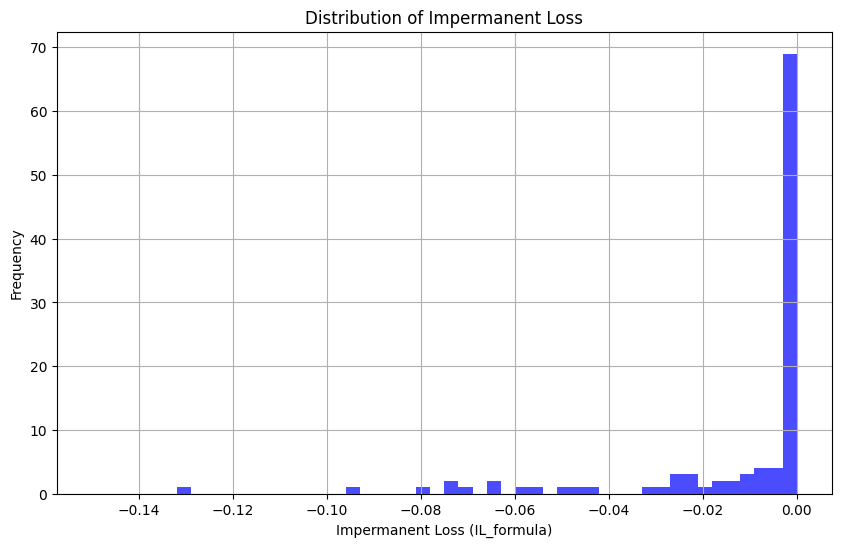

In [113]:
import matplotlib.pyplot as plt
# Histogram of Impermanent Loss
plt.figure(figsize=(10, 6))
plt.hist(combined_df['IL_final'], bins=50, color='blue', alpha=0.7, range=(-0.15, 0))
plt.title('Distribution of Impermanent Loss')
plt.xlabel('Impermanent Loss (IL_formula)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

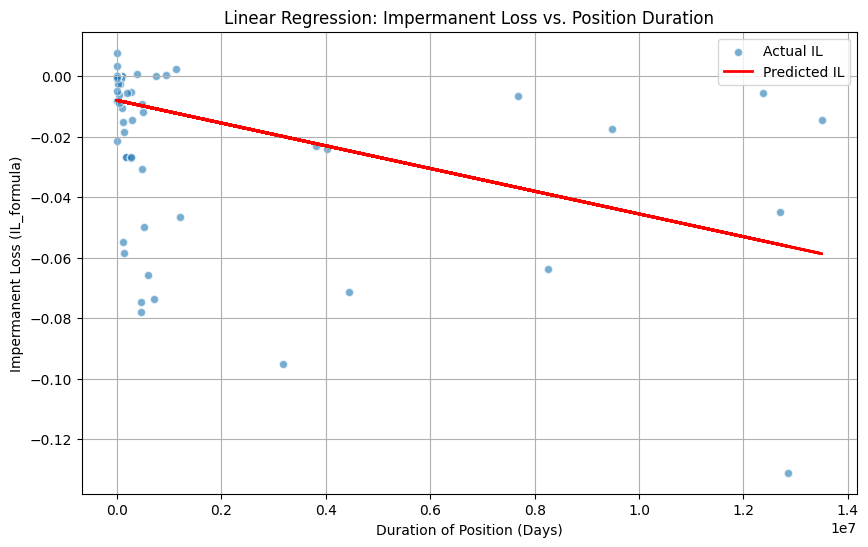

Slope (Coefficient): -3.756857127988789e-09
Intercept: -0.007943460779906673
R-squared value: 0.1912


In [128]:
from sklearn.linear_model import LinearRegression

# Prepare the features (X) and the target (y)
X = combined_df[['weightedDurationSeconds']]  # features need to be 2D for sklearn
y = combined_df['IL_final']  # target

# Create a linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
combined_df['predicted_IL'] = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, edgecolors='w', label='Actual IL')
plt.plot(X, combined_df['predicted_IL'], color='red', linewidth=2, label='Predicted IL')
plt.title('Linear Regression: Impermanent Loss vs. Position Duration')
plt.xlabel('Duration of Position (Days)')
plt.ylabel('Impermanent Loss (IL_formula)')
plt.legend()
plt.grid(True)
plt.show()

# Print the coefficients
print("Slope (Coefficient):", model.coef_[0])
print("Intercept:", model.intercept_)

r_squared = model.score(X, y)
print(f'R-squared value: {r_squared:.4f}')

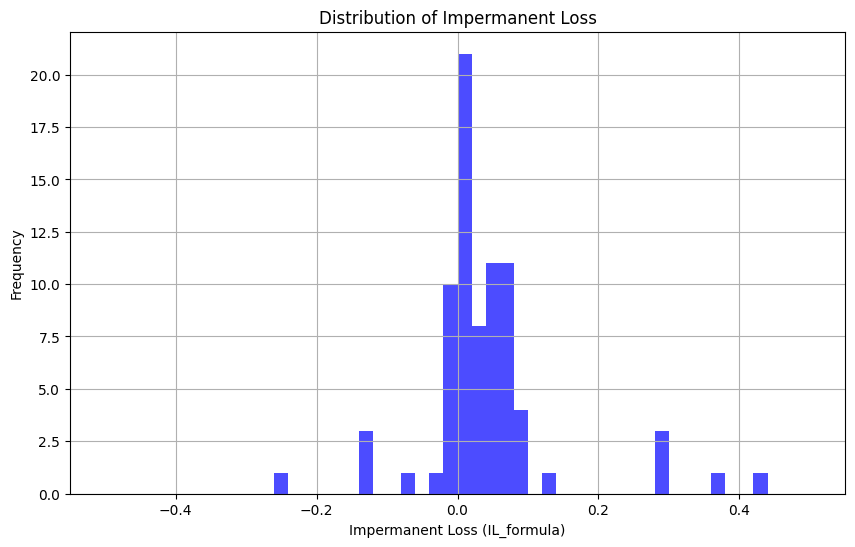

In [125]:
plt.figure(figsize=(10, 6))
plt.hist(combined_df['relative_return'], bins=50, color='blue', alpha=0.7, range=(-0.5, 0.5))
plt.title('Distribution of Impermanent Loss')
plt.xlabel('Impermanent Loss (IL_formula)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Our sample includes transactions from a timespan of 34 months, starting from June 1st 2021 until April 1st 2024. Since Uniswap was launched on May 5 2021 on the Ethereum mainnet, there is only limited data available. The sample only considers liquidity positions that were closed during that interval. The relatively long timespan was chosen to even out the temporary effects of market cycles, that also affect the volume of Uniswap v3.

In [1]:
ZERO = 0
Q128 = 2 ** 128
Q256 = 2 ** 256

def subIn256(x, y):
    difference = x - y
    if difference < ZERO:
        return Q256 + difference
    else:
        return difference

def toBigNumber(value):
    return int(value)  # Convert string or number to Python integer, in case large number is in strign format

def getFees(feeGrowthGlobal0, feeGrowthGlobal1, feeGrowth0Low, feeGrowth0Hi, feeGrowthInside0, feeGrowth1Low, feeGrowth1Hi, feeGrowthInside1, liquidity, decimals0, decimals1, tickLower, tickUpper, tickCurrent):
    feeGrowthGlobal_0 = toBigNumber(feeGrowthGlobal0)
    feeGrowthGlobal_1 = toBigNumber(feeGrowthGlobal1)
    tickLowerFeeGrowthOutside_0 = toBigNumber(feeGrowth0Low)
    tickLowerFeeGrowthOutside_1 = toBigNumber(feeGrowth1Low)
    tickUpperFeeGrowthOutside_0 = toBigNumber(feeGrowth0Hi)
    tickUpperFeeGrowthOutside_1 = toBigNumber(feeGrowth1Hi)
    tickLowerFeeGrowthBelow_0 = ZERO
    tickLowerFeeGrowthBelow_1 = ZERO
    tickUpperFeeGrowthAbove_0 = ZERO
    tickUpperFeeGrowthAbove_1 = ZERO

    if tickCurrent >= tickUpper:
        tickUpperFeeGrowthAbove_0 = subIn256(feeGrowthGlobal_0, tickUpperFeeGrowthOutside_0)
        tickUpperFeeGrowthAbove_1 = subIn256(feeGrowthGlobal_1, tickUpperFeeGrowthOutside_1)
    else:
        tickUpperFeeGrowthAbove_0 = tickUpperFeeGrowthOutside_0
        tickUpperFeeGrowthAbove_1 = tickUpperFeeGrowthOutside_1

    if tickCurrent >= tickLower:
        tickLowerFeeGrowthBelow_0 = tickLowerFeeGrowthOutside_0
        tickLowerFeeGrowthBelow_1 = tickLowerFeeGrowthOutside_1
    else:
        tickLowerFeeGrowthBelow_0 = subIn256(feeGrowthGlobal_0, tickLowerFeeGrowthOutside_0)
        tickLowerFeeGrowthBelow_1 = subIn256(feeGrowthGlobal_1, tickLowerFeeGrowthOutside_1)

    fr_t1_0 = subIn256(subIn256(feeGrowthGlobal_0, tickLowerFeeGrowthBelow_0), tickUpperFeeGrowthAbove_0)
    fr_t1_1 = subIn256(subIn256(feeGrowthGlobal_1, tickLowerFeeGrowthBelow_1), tickUpperFeeGrowthAbove_1)
    feeGrowthInsideLast_0 = toBigNumber(feeGrowthInside0)
    feeGrowthInsideLast_1 = toBigNumber(feeGrowthInside1)

    uncollectedFees_0 = (liquidity * subIn256(fr_t1_0, feeGrowthInsideLast_0)) // Q128
    uncollectedFees_1 = (liquidity * subIn256(fr_t1_1, feeGrowthInsideLast_1)) // Q128

    uncollectedFeesAdjusted_0 = uncollectedFees_0 / (10 ** decimals0)
    uncollectedFeesAdjusted_1 = uncollectedFees_1 / (10 ** decimals1)
    print(f"Amount fees token 0 in lowest decimal: {int(uncollectedFees_0)}")
    print(f"Amount fees token 1 in lowest decimal: {int(uncollectedFees_1)}")
    print(f"Amount fees token 0 Human format: {uncollectedFeesAdjusted_0:.{decimals0}f}")
    print(f"Amount fees token 1 Human format: {uncollectedFeesAdjusted_1:.{decimals1}f}")


In [2]:
getFees(3094836483914812667943230173936420,1,37180414779992829129391081655145,233371140530963296710329726203514,0,1,1,1,10860507277202,6,6,192180,193380,201780)
getFees(1598689279610056278300511697452980233550428,3435711821068543428641395387486415,828485853430476009282010998184629866963795,168474001916454882792751774532376246302129,599406432805413676403104389099663458397584,1207675746724748089633601970657256,633890610051325028869533762979989,1588710658195404578212538675916747,1455242849752042,18,6,200340,195420,196082)
getFees()

Amount fees token 0 in lowest decimal: 6261655
Amount fees token 1 in lowest decimal: 3695639122248373304231208116609338612196379944026111
Amount fees token 0 Human format: 6.261655
Amount fees token 1 Human format: 3695639122248373590578266900963621657483673600.000000
Amount fees token 0 in lowest decimal: 495193481358396479108080074813186106532318883319618272
Amount fees token 1 in lowest decimal: 495193481358396479108080074813186111669065693812072227
Amount fees token 0 Human format: 495193481358396475439740762330234880.000000000000000000
Amount fees token 1 Human format: 495193481358396497867848624699518333549748944896.000000


Code for python Async Requests (API Calls)

In [260]:

class LiquidityProvider:
    def __init__(self, address):
        """
        Initializes a new LiquidityProvider instance.

        Parameters:
        address (str): The Ethereum address of the liquidity provider.
        """
        self.address = address
        self.positions = []

    def add_position(self, position):
        """
        Adds a new position to the liquidity provider's list of positions.

        Parameters:
        position (Position): The position to be added to this provider.
        """
        self.positions.append(position)
        position.provider = self  # Establish the reverse link from Position to LiquidityProvider

    def get_positions(self):
        """
        Returns a list of all positions for this liquidity provider.
        """
        return self.positions

    def __str__(self):
        """
        Returns a string representation of the LiquidityProvider object.
        """
        return f"Liquidity Provider Address: {self.address}"

class Event:

    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):
        """
        Initializes a new Event instance.

        Parameters:
        block_number (int): The block number at which the event occurred.
        amount (float): The amount of liquidity involved in the event.
        """
        self.blocknumber = blocknumber
        self.collectedFeesToken0 = collectedFeesToken0
        self.collectedFeesToken1 = collectedFeesToken1
        self.depositedToken0 = depositedToken0
        self.depositedToken1 = depositedToken1
        self.feeGrowthInside0LastX128 = feeGrowthInside0LastX128
        self.feeGrowthInside1LastX128 = feeGrowthInside1LastX128
        self.id = id
        self.withdrawnToken0 = withdrawnToken0
        self.withdrawnToken1 = withdrawnToken1
        self.timestamp = timestamp
        self.liquidity = liquidity
        self.amount0 = amount0
        self.amount1 = amount1
        self.amountUSD = amountUSD
        self.tokenPrice0 = 0.5 * amountUSD / amount0
        self.tokenPrice1 = 0.5 * amountUSD / amount1



    def __str__(self):
        """
        Return a basic representation of the event, should be overridden by subclasses.
        """
        return f"Event at Block {self.block_number}, Amount: {self.amount}"

class Mint(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        self.isInitialMint = False
        self.amount = amount

    def __str__(self):
        return f"Mint: Block {self.block_number}, Amount: {self.amount}"

class Burn(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        self.isFinalBurn = False
        self.amount = amount

    def __str__(self):
        return f"Burn: Block {self.block_number}, Amount: {self.amount}"
    
class Collect(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):

    def __str__(self):
        return f"Collect: Block {self.block_number}"
    
class Tick:
    def __init__(self, idx, price0, price1, feeGrowthOutside0X128, feeGrowthOutside1X128):
        """
        Initializes a new Tick instance.

        Parameters:
        price0 (float): The price of token0 in this tick.
        price1 (float): The price of token1 in this tick.
        feeGrowthOutside0X128 (int): The fee growth outside of this tick for token0.
        feeGrowthOutside1X128 (int): The fee growth outside of this tick for token1.
        """
        self.idx = idx
        self.price0 = price0
        self.price1 = price1
        self.feeGrowthOutside0X128 = feeGrowthOutside0X128
        self.feeGrowthOutside1X128 = feeGrowthOutside1X128

    def __str__(self):
        return f"Tick: {self.idx}"


class Position:
    def __init__(self, id, liquidity, owner, pool, amountCollectedUSD, amountDepositedUSD, amountWithdrawnUSD, collectedFeesToken0, collectedFeesToken1, collectedToken0, collectedToken1, initialDepositToken0, initialDepositToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, tickLower, tickUpper, withdrawnToken0, withdrawnToken1):
        """
        Initializes a new Position instance.

        Parameters:
        provider (LiquidityProvider): The liquidity provider associated with this position.
        events (list of Event): A list of events associated with this position.
        """
        self.id = id
        self.liquidity = liquidity
        self.owner = owner
        self.pool = pool #pass Pool object, not in df
        self.token1 = pool.token1
        self.token0 = pool.token0
        self.amountCollectedUSD = amountCollectedUSD
        self.amountDepositedUSD = amountDepositedUSD
        self.amountWithdrawnUSD = amountWithdrawnUSD
        self.collectedFeesToken0 = collectedFeesToken0
        self.collectedFeesToken1 = collectedFeesToken1
        self.collectedToken0 = collectedToken0
        self.collectedToken1 = collectedToken1
        self.initialDepositToken0 = initialDepositToken0 # depositedToken= in TheGraph
        self.initialDepositToken1 = initialDepositToken1
        self.feeGrowthInside0LastX128 = feeGrowthInside0LastX128
        self.feeGrowthInside1LastX128 = feeGrowthInside1LastX128    
        self.tickLower = tickLower
        self.tickUpper = tickUpper
        self.withdrawnToken0 = withdrawnToken0
        self.withdrawnToken1 = withdrawnToken1
        self.events = []

    def add_event(self, event):
        """
        Adds a new event to the position's list of events.

        Parameters:
        event (Event): The event to be added to this position.
        """
        self.events.append(event)
        event.position = self  # Establish the reverse link from Event to Position
        self.events.sort(key=lambda x: x.block_number)

    def getHODLvalue(self, price0, price1):
        value = self.events.amount0 * price0 + self.events.amount1 * price1
        return value
    
    def getFinalHODLvalue(self):
        # get the last mint event and conmpute the value of the position at that time
        mint_event = max([event for event in self.events if isinstance(event, Mint)], key=lambda event: event.block_number)
        burn_event = max([event for event in self.events if isinstance(event, Burn)], key=lambda event: event.block_number)
        return mint_event.amount0 * burn_event.tokenPrice0 + burn_event.tokenPrice1 * mint_event.amount1
        

    def compute_balances(self):
        """
        Computes the current(remaining) liquidity for the position based on the events.
        """
        self.currentLiquidity = 0
        for event in self.events:
            if isinstance(event, Mint):
                self.currentLiquidity += event.liquidity
            elif isinstance(event, Burn):
                self.currentLiquidity -= event.liquidity 

    def compute_IL(self):
        """
        Computes the impermanent loss for the position based on the events.
        """
        self.IL = 0
        for event in self.events:
            if isinstance(event, Mint):
                self.IL += event.liquidity
            elif isinstance(event, Burn):
                self.IL -= event.liquidity

    def add_liquidity_provider(self, provider):
        """
        Adds a new liquidity provider to the position.

        Parameters:
        provider (LiquidityProvider): The liquidity provider to be added to this position.
        """
        self.provider = provider # Establish the link from Position to LiquidityProvider

    def get_events(self):
        """
        Returns a list of all events for this position.
        """
        return self.events
    
    def get_provider(self):
        """
        Returns the liquidity provider associated with this position.
        """
        return self.provider

    def __str__(self):
        events_str = "\n".join([str(event) for event in self.events])
        return f"Position for {self.provider}\nEvents:\n{events_str}"


class PoolSample:
    def __init__(self, pool: Pool):
        self.pool = pool
        self.positions = []

    def add_position(self, position:Position):
        self.positions.append(position)
        position.pool = self
